In [2]:
!pip install torch torchvision torchaudio
!pip install transformers[torch]
!pip install transformers
!pip install accelerate -U


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [4]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
import transformers
import torch
import accelerate
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import classification_report
from torch.nn import CrossEntropyLoss
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
import torch, torch.utils.data
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
import string
from string import punctuation
from nltk.corpus import stopwords
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd drive/MyDrive/Cs412/project_files

/content/drive/MyDrive/Cs412/project_files


In [7]:
train_df = pd.read_csv('bugs-train.csv')
test_df = pd.read_csv('bugs-test.csv')

In [8]:
# Display the first few rows of the training dataset
print("First few rows of the training dataset:")
print(train_df.head())

# Check for class imbalance in the training set
severity_counts = train_df['severity'].value_counts()
print("\nDistribution of Bug Severity in Training Set:")
print(severity_counts)

First few rows of the training dataset:
   bug_id                                            summary  severity
0  365569                  Remove workaround from bug 297227    normal
1  365578    Print Preview crashes on any URL in gtk2 builds  critical
2  365582                     Lines are not showing in table     major
3  365584  Firefox render ÛÏsimplified ArabicÛ font fa...    normal
4  365597             Crash [@ nsINodeInfo::NodeInfoManager]  critical

Distribution of Bug Severity in Training Set:
severity
normal         125854
critical        18658
major            6053
enhancement      4426
minor            3102
trivial          1204
blocker           701
Name: count, dtype: int64


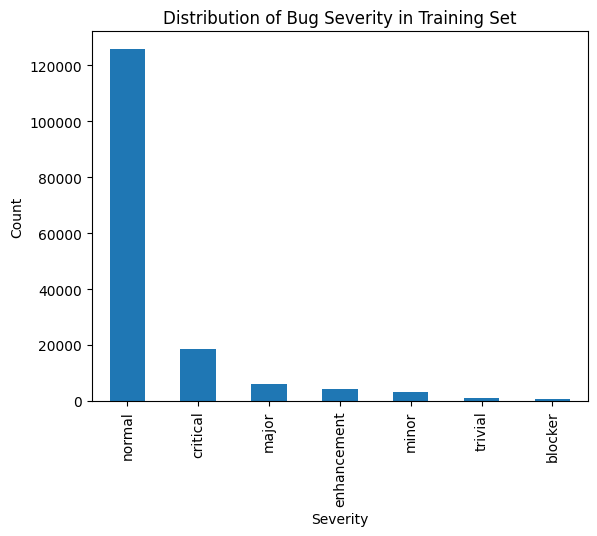

In [9]:
# Plot the distribution of bug severity in the training set
severity_counts.plot(kind='bar')
plt.xlabel('Severity')
plt.ylabel('Count')
plt.title('Distribution of Bug Severity in Training Set')
plt.show()


In [10]:
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    return ''.join(text)

In [11]:
def remove_stopwords(git_text):
    # filters charecter-by-charecter : ['h', 'e', 'e', 'l', 'o', 'o', ' ', 'm', 'y', ' ', 'n', 'a', 'm', 'e', ' ', 'i', 's', ' ', 'p', 'u', 'r', 'v', 'a']
    remove_punctuation = [ch for ch in git_text if ch not in punctuation]
    # convert them back to sentences and split into words
    remove_punctuation = "".join(remove_punctuation).split()
    filtered_git_text = [word.lower() for word in remove_punctuation if word.lower() not in stopwords.words('english')]
    return filtered_git_text

In [ ]:
from collections import Counter
import plotly.express as px

def visulize_dataset(data_frame):

    # Let's apply the above two functions 'clean_text' and 'remove_stopwords' to the whole dataset

    data_frame['summary'] = data_frame['summary'].apply(lambda x: x.replace("\\r", ""))
    data_frame['summary'] = data_frame['summary'].apply(clean_text)
    data_frame["summary"] = data_frame["summary"].apply(remove_stopwords)


    word_list = []

    for i, j in data_frame.iterrows():
        for word in j['text']:
            word_list.append(word)

    count_dict = Counter(word_list)
    most_common_words_df = pd.DataFrame(count_dict.most_common(20), columns=['word', 'count'])
    fig = px.histogram(most_common_words_df,
                       x='word',
                       y='count',
                       title='Most common terms used while refering to a GitHub',
                       color_discrete_sequence=['#843B62'] )
    fig.show()

In [10]:

# Remove rows with non-English characters in the 'summary' column
#train_df['summary'] = train_df[train_df['summary'].apply(clean_text)]
#train_df['summary'] = train_df['summary'].apply(lambda x: x.replace("\\r", ""))
#train_df['summary'] = train_df["summary"].apply(clean_text)

#test_df['summary'] = test_df['summary'].apply(lambda x: x.replace("\\r", ""))
#test_df['summary'] = test_df["summary"].apply(clean_text)
# Check for missing values and drop them
train_df = train_df.dropna()
print(train_df.head())

# Split data into training and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['severity'], random_state=42)

train_df.shape, val_df.shape


   bug_id                                            summary  severity
0  365569                  Remove workaround from bug 297227    normal
1  365578    Print Preview crashes on any URL in gtk2 builds  critical
2  365582                     Lines are not showing in table     major
3  365584  Firefox render ÛÏsimplified ArabicÛ font fa...    normal
4  365597             Crash [@ nsINodeInfo::NodeInfoManager]  critical


((127998, 3), (32000, 3))

In [11]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize summaries
train_encodings = tokenizer(train_df['summary'].tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_df['summary'].tolist(), truncation=True, padding=True, max_length=128)

train_encodings.keys()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [12]:
# Convert labels to numeric data
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df['severity'])
val_labels = label_encoder.transform(val_df['severity'])


In [16]:
# Print the mapping of original labels to encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'blocker': 0, 'critical': 1, 'enhancement': 2, 'major': 3, 'minor': 4, 'normal': 5, 'trivial': 6}


In [ ]:
sampling_strategy={
    0: 5000,   #blocker
    1: 50000,  # critical
    2: 15000,  # enhancement
    3: 20000,  # major
    4: 10000,   # minor
    6 : 7000  # trivial
    },

In [17]:
# Apply SMOTE to the training data
smote = SMOTE(
    sampling_strategy={
    0: 5000,   #blocker
    1: 50000,  # critical
    2: 15000,  # enhancement
    3: 20000,  # major
    4: 10000,   # minor
    6 : 7000  # trivial
    },
    random_state=42, k_neighbors=8, n_jobs=-1,)
train_features_resampled, train_labels_resampled = smote.fit_resample(train_encodings['input_ids'], train_labels)
'''

smotetomek = SMOTETomek(sampling_strategy='auto', random_state=42, n_jobs=-1)
train_features_resampled, train_labels_resampled = smotetomek.fit_resample(train_encodings['input_ids'], train_labels)
'''

# Convert resampled features back to tensors
train_encodings_resampled = {
    'input_ids': torch.tensor(train_features_resampled, dtype=torch.long),
    'attention_mask': torch.tensor(smote.fit_resample(train_encodings['attention_mask'], train_labels)[0], dtype=torch.long)
}

/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels_resampled), y=train_labels_resampled)
class_weights = torch.tensor(class_weights, dtype=torch.float)
# Move class weights to the same device as the model
class_weights = class_weights.to(device)

In [20]:
# Custom dataset class
class BugDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [21]:
# Create dataset objects
train_dataset = BugDataset(train_encodings_resampled, train_labels_resampled)
val_dataset = BugDataset(val_encodings, val_labels)

In [22]:

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=7)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


In [24]:
training_args = TrainingArguments(
    output_dir= './results',
    learning_rate=2e-5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    fp16=True
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [25]:
# Define compute_metrics function using classification_report
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    report = classification_report(labels, preds, output_dict=True)
    return {
        'accuracy': report['accuracy'],
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1': report['weighted avg']['f1-score'],
        'macro_precision': report['macro avg']['precision'],
        'macro_recall': report['macro avg']['recall'],
        'macro_f1': report['macro avg']['f1-score']
    }

In [ ]:

# Custom Trainer class to incorporate class weights
class WeightedLossTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get('labels')
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss
# Trainer
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    class_weights=class_weights
)


In [26]:
# Define Focal Loss
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = torch.nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss

# Custom Trainer class to incorporate Focal Loss
class FocalLossTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.criterion = FocalLoss()

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get('labels')
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss = self.criterion(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Trainer
trainer_f = FocalLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)


In [27]:
# Check if GPU is available
if torch.cuda.is_available():
    print("CUDA is available. Training on GPU.")
else:
    print("CUDA is not available. Training on CPU.")


CUDA is available. Training on GPU.


In [28]:

# Train the model
trainer_f.train()

<ipython-input-20-2eab11771b5d>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Macro Precision,Macro Recall,Macro F1
1,0.473700,0.256071,0.863219,0.807172,0.863219,0.822849,0.471478,0.261003,0.268753


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-20-2eab11771b5d>:8: UserWarning: To copy construc

KeyboardInterrupt: 

## Test Not preprocessed

In [35]:

# Evaluate the model
eval_result = trainer_f.evaluate()
print(f"Evaluation result: {eval_result}")

# Tokenize test data
test_encodings = tokenizer(test_df['summary'].tolist(), truncation=True, padding=True, max_length=128)

# Create test dataset
test_dataset = BugDataset(test_encodings, [0] * len(test_df))  # Dummy labels since we don't have them

# Predict labels for test data
test_predictions = trainer_f.predict(test_dataset)

# Convert numeric labels back to original labels
predicted_labels = label_encoder.inverse_transform(np.argmax(test_predictions.predictions, axis=1))

# Prepare submission file
submission_df = pd.DataFrame({'bug_id': test_df['bug_id'], 'predicted_label': predicted_labels})
submission_df.to_csv('submission.csv', index=False)

Evaluation result: {'eval_loss': 0.23728790879249573, 'eval_accuracy': 0.865375, 'eval_precision': 0.8427267563676525, 'eval_recall': 0.865375, 'eval_f1': 0.8279183784913372, 'eval_macro_precision': 0.7273362170666793, 'eval_macro_recall': 0.2801232447614201, 'eval_macro_f1': 0.297597191597042, 'eval_runtime': 30.5047, 'eval_samples_per_second': 1049.02, 'eval_steps_per_second': 8.195, 'epoch': 1.0}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
# Save the model at the end of each epoch (you can adjust the checkpoint saving frequency as needed)
trainer_f.save_model('./results/epoch1')  # Save model after first epoch

In [ ]:
# Remove rows with non-English characters in the 'summary' column
#train_df['summary'] = train_df[train_df['summary'].apply(clean_text)]

# Tokenize test data
test_encodings = tokenizer(test_df['summary'].tolist(), truncation=True, padding=True, max_length=128)

# Create test dataset
test_dataset = BugDataset(test_encodings, [0] * len(test_df))  # Dummy labels since we don't have them

# Predict labels for test data
test_predictions = trainer.predict(test_dataset)

# Convert numeric labels back to original labels
predicted_labels = label_encoder.inverse_transform(np.argmax(test_predictions.predictions, axis=1))

# Prepare submission file
submission_df = pd.DataFrame({'bug_id': test_df['bug_id'], 'predicted_label': predicted_labels})
submission_df.to_csv('submission.csv', index=False)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
